# MIE1628S 2025 A3: Spark and Cloud Data Platform

In [0]:
#import all necessay package
from pyspark.rdd import RDD
from pyspark.sql.types import StructType, StructField, IntegerType, StringType
import matplotlib.pyplot as plt
from pyspark.sql.functions import when, col
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

### _**Part A: [Marks 60]**_

_**Input Data - kddcup.data_10_percent.gz 10% subset. (2.1M; 75M Uncompressed) from http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html Please read the paper provided with your assignment in the Quercus and answer the following question.**_


**Use the python urllib library to extract the KDD Cup 99 data from their web
repository, store it in a temporary location and then move it to the Databricks filesystem which
can enable easy access to this data for analysis.**

In [0]:
import urllib.request
urllib.request.urlretrieve("http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz", "/tmp/kddcup_data.gz")
dbutils.fs.mv("file:/tmp/kddcup_data.gz", "dbfs:/kdd/kddcup_data.gz")
display(dbutils.fs.ls("dbfs:/kdd"))

path,name,size,modificationTime
dbfs:/kdd/kddcup_data.gz,kddcup_data.gz,2144903,1751085020000


**After storing the data in the Databricks filesystem. Load your data from the disk
into Spark's RDD. Print 10 values of your RDD and verify the type of data structure of your
data (RDD).**

In [0]:
my_rdd = spark.sparkContext.textFile("dbfs:/kdd/kddcup_data.gz")

In [0]:
print("10 values of my RDD:\n", my_rdd.take(10))

10 values of my RDD:
 ['0,tcp,http,SF,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,9,9,1.00,0.00,0.11,0.00,0.00,0.00,0.00,0.00,normal.', '0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,19,19,1.00,0.00,0.05,0.00,0.00,0.00,0.00,0.00,normal.', '0,tcp,http,SF,235,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,29,29,1.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,normal.', '0,tcp,http,SF,219,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.00,0.00,1.00,0.00,0.00,39,39,1.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,normal.', '0,tcp,http,SF,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.00,0.00,1.00,0.00,0.00,49,49,1.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,normal.', '0,tcp,http,SF,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.00,0.00,1.00,0.00,0.00,59,59,1.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,normal.', '0,tcp,http,SF,212,1940,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,2,0.00,0.00,0.00

In [0]:
print("Data structure of the dataset: \n", type(my_rdd))

#verify the type of data structure
if isinstance(my_rdd, RDD):
    print("The data structure is RDD")
else:
    print("The data structure is not RDD!!!")

Data structure of the dataset: 
 <class 'pyspark.rdd.RDD'>
The data structure is RDD


**Split the data. (Each entry in your RDD is a comma-separated line of data, which
you first need to split before you can parse and build your data frame.) Show the total number
of features (columns) and print results.**

In [0]:
split_rdd = my_rdd.map(lambda line: line.split(","))
print(f"Number of features: {len(split_rdd.first())}")

Number of features: 42


In [0]:
#show some example
for row in split_rdd.take(10):
    print(row)

['0', 'tcp', 'http', 'SF', '181', '5450', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '8', '8', '0.00', '0.00', '0.00', '0.00', '1.00', '0.00', '0.00', '9', '9', '1.00', '0.00', '0.11', '0.00', '0.00', '0.00', '0.00', '0.00', 'normal.']
['0', 'tcp', 'http', 'SF', '239', '486', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '8', '8', '0.00', '0.00', '0.00', '0.00', '1.00', '0.00', '0.00', '19', '19', '1.00', '0.00', '0.05', '0.00', '0.00', '0.00', '0.00', '0.00', 'normal.']
['0', 'tcp', 'http', 'SF', '235', '1337', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '8', '8', '0.00', '0.00', '0.00', '0.00', '1.00', '0.00', '0.00', '29', '29', '1.00', '0.00', '0.03', '0.00', '0.00', '0.00', '0.00', '0.00', 'normal.']
['0', 'tcp', 'http', 'SF', '219', '1337', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '6', '6', '0.00', '0.00', '0.00', '0.00', '1.00', '0.00'

**Now extract these 6 columns (duration, protocol_type, service, src_bytes,
dst_bytes, flag and label) from your dataset. Build a new RDD and data frame. Print schema
and display 10 values.**


In [0]:
schema_names = ["duration","protocol_type", "service", "flag", "src_bytes","dst_bytes", "label"]

def extract_fields(row):
    return (
        int(row[0]),  # duration
        row[1],# protocol_type
        row[2], # service
        row[3], # flag ← FIXED!
        int(row[4]), # src_bytes
        int(row[5]),  # dst_bytes
        row[41] # label
    )


filtered_rdd = split_rdd.map(extract_fields)

#apply the schema
extracted_df = spark.createDataFrame(filtered_rdd, schema=schema_names)

#print
extracted_df.printSchema()


root
 |-- duration: long (nullable = true)
 |-- protocol_type: string (nullable = true)
 |-- service: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- src_bytes: long (nullable = true)
 |-- dst_bytes: long (nullable = true)
 |-- label: string (nullable = true)



In [0]:
extracted_df.show(10)

+--------+-------------+-------+----+---------+---------+-------+
|duration|protocol_type|service|flag|src_bytes|dst_bytes|  label|
+--------+-------------+-------+----+---------+---------+-------+
|       0|          tcp|   http|  SF|      181|     5450|normal.|
|       0|          tcp|   http|  SF|      239|      486|normal.|
|       0|          tcp|   http|  SF|      235|     1337|normal.|
|       0|          tcp|   http|  SF|      219|     1337|normal.|
|       0|          tcp|   http|  SF|      217|     2032|normal.|
|       0|          tcp|   http|  SF|      217|     2032|normal.|
|       0|          tcp|   http|  SF|      212|     1940|normal.|
|       0|          tcp|   http|  SF|      159|     4087|normal.|
|       0|          tcp|   http|  SF|      210|      151|normal.|
|       0|          tcp|   http|  SF|      212|      786|normal.|
+--------+-------------+-------+----+---------+---------+-------+
only showing top 10 rows



**Get the total number of connections based on the protocol_type and based on the service. Show results in an ascending order. Plot the bar graph for both.**

In [0]:
#define function to plot
def extract_plot_connection_count_bar_chart(df, label,figsize=(8, 4)):
    #extract the count
    category_counts = df.groupBy(label).count().orderBy("count")
    category_counts.show()
    category_counts_pd = category_counts.toPandas()
    
    # Plot
    plt.figure(figsize=figsize)
    plt.bar(category_counts_pd[label], category_counts_pd["count"])
    plt.title(f"Connection Count by {label}")
    plt.xlabel(label)
    plt.xticks(rotation=90)
    plt.ylabel("Connection Count Number")
    plt.tight_layout()
    plt.show()

+-------------+------+
|protocol_type| count|
+-------------+------+
|          udp| 20354|
|          tcp|190065|
|         icmp|283602|
+-------------+------+



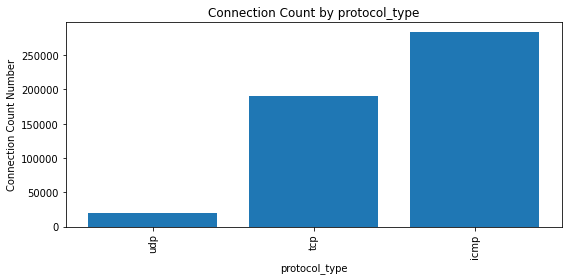

In [0]:
#protocal type vs connections
extract_plot_connection_count_bar_chart(extracted_df,"protocol_type")

+-----------+-----+
|    service|count|
+-----------+-----+
|     tftp_u|    1|
|    pm_dump|    1|
|      red_i|    1|
|      tim_i|    7|
|        X11|   11|
|      urh_i|   14|
|        IRC|   43|
|     Z39_50|   92|
|    netstat|   95|
|        ctf|   97|
|       name|   98|
|     kshell|   98|
|       exec|   99|
|netbios_dgm|   99|
|   http_443|   99|
|       ldap|  101|
|      pop_2|  101|
|       link|  102|
| netbios_ns|  102|
|    daytime|  103|
+-----------+-----+
only showing top 20 rows



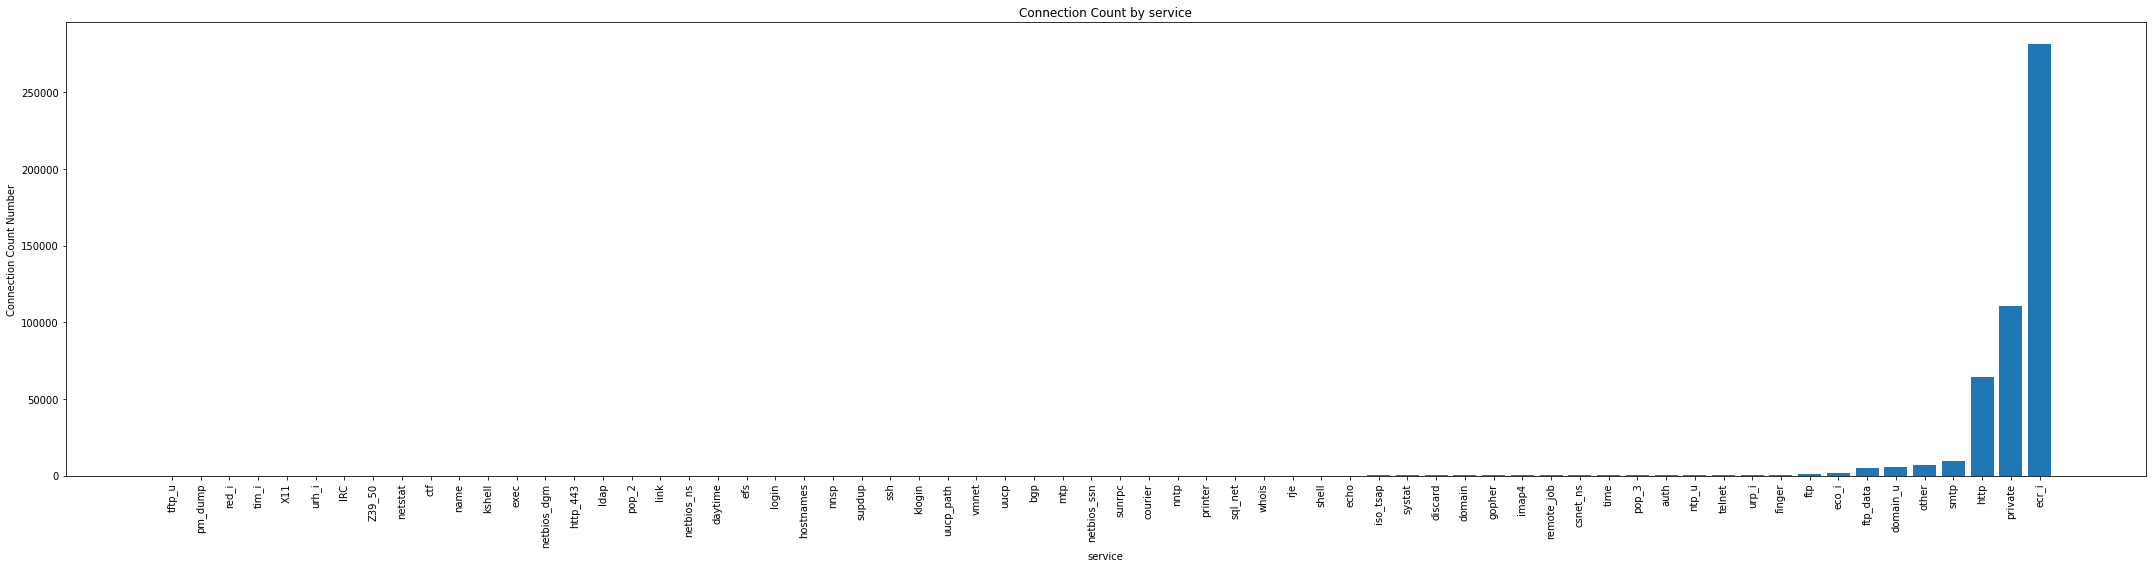

In [0]:
#service vs connections
extract_plot_connection_count_bar_chart(extracted_df,"service",(30,8))

**Do a further exploratory data analysis, including other columns of this dataset and
plot graphs. Plot at least 3 different charts and explain them**


+------+------+
|  flag| count|
+------+------+
|   OTH|     8|
|    S3|    10|
|RSTOS0|    11|
|    S2|    24|
|    S1|    57|
|    SH|   107|
|  RSTO|   579|
|  RSTR|   903|
|   REJ| 26875|
|    S0| 87007|
|    SF|378440|
+------+------+



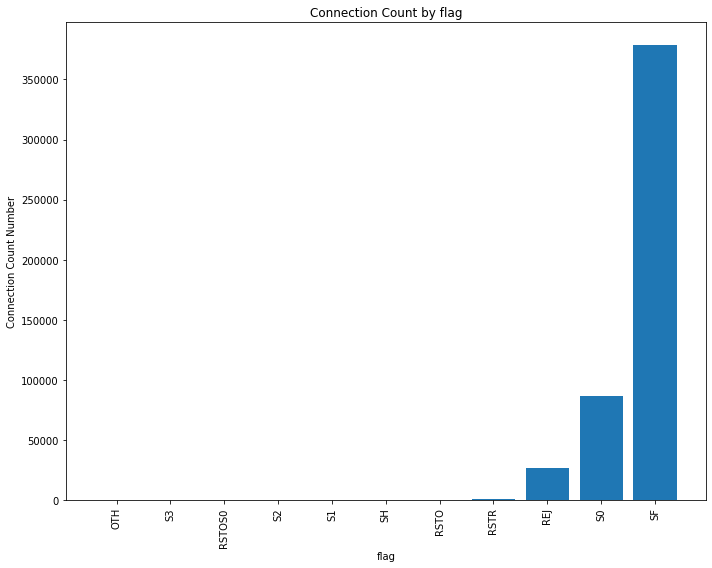

In [0]:
#explore the flag vs connection 
extract_plot_connection_count_bar_chart(extracted_df,"flag",(10,8))

+----------------+-----+
|           label|count|
+----------------+-----+
|            spy.|    2|
|           perl.|    3|
|            phf.|    4|
|       multihop.|    7|
|      ftp_write.|    8|
|     loadmodule.|    9|
|        rootkit.|   10|
|           imap.|   12|
|    warezmaster.|   20|
|           land.|   21|
|buffer_overflow.|   30|
|   guess_passwd.|   53|
|           nmap.|  231|
|            pod.|  264|
|       teardrop.|  979|
|    warezclient.| 1020|
|      portsweep.| 1040|
|        ipsweep.| 1247|
|          satan.| 1589|
|           back.| 2203|
+----------------+-----+
only showing top 20 rows



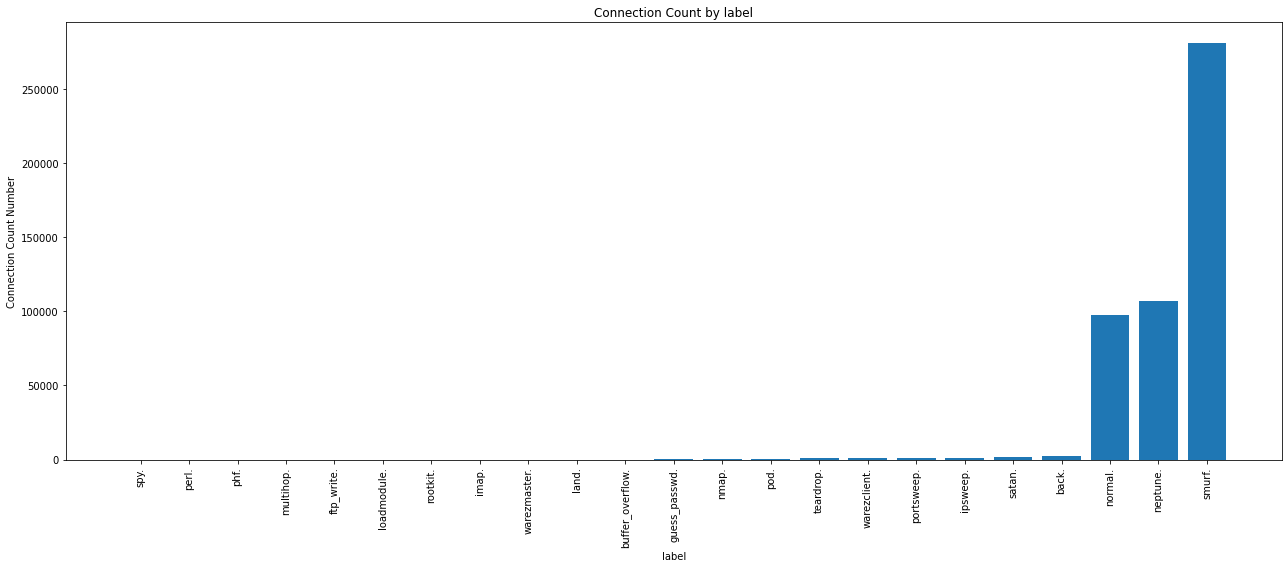

In [0]:
#explore the label vs connection
extract_plot_connection_count_bar_chart(extracted_df,"label",(18,8))

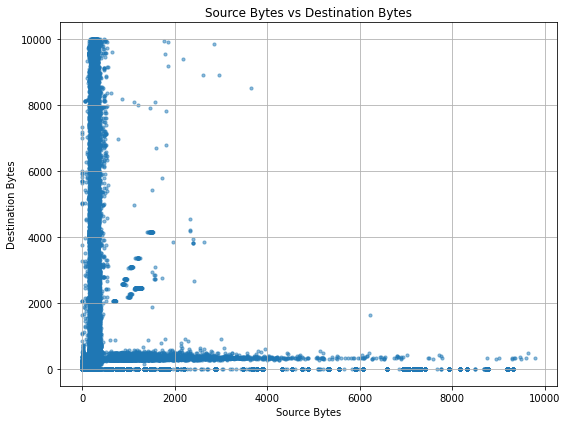

In [0]:
#a scatter plot between scr_bytes and dst bytes
bytes_pd = extracted_df.select("src_bytes", "dst_bytes").toPandas()

#remove outlier
bytes_pd_filtered = bytes_pd[(bytes_pd["src_bytes"] < 10000) & (bytes_pd["dst_bytes"] < 10000)]

plt.figure(figsize=(8, 6))
plt.scatter(bytes_pd_filtered["src_bytes"], bytes_pd_filtered["dst_bytes"], alpha=0.5, s=10)
plt.title("Source Bytes vs Destination Bytes")
plt.xlabel("Source Bytes")
plt.ylabel("Destination Bytes")
plt.grid(True)
plt.tight_layout()
plt.show()

**Look at the label column where label == ‘normal’. Now create a new label column
where you have a label == ‘normal’ and everything else is considered as an ‘attack’. Split your
data (train/test) and based on your new label column now build a simple machine learning
model for intrusion detection (you can use few selected columns for your model out of all).
Explain which algorithm you have selected and why. Show the results with some success
metrics.**


- Use Linear SVC model

In [0]:

# map label to normal and attack
labeled_df = extracted_df.withColumn("label_new", when(col("label") == "normal.", "normal").otherwise("attack"))

labeled_df.show()

+--------+-------------+-------+----+---------+---------+-------+---------+
|duration|protocol_type|service|flag|src_bytes|dst_bytes|  label|label_new|
+--------+-------------+-------+----+---------+---------+-------+---------+
|       0|          tcp|   http|  SF|      181|     5450|normal.|   normal|
|       0|          tcp|   http|  SF|      239|      486|normal.|   normal|
|       0|          tcp|   http|  SF|      235|     1337|normal.|   normal|
|       0|          tcp|   http|  SF|      219|     1337|normal.|   normal|
|       0|          tcp|   http|  SF|      217|     2032|normal.|   normal|
|       0|          tcp|   http|  SF|      217|     2032|normal.|   normal|
|       0|          tcp|   http|  SF|      212|     1940|normal.|   normal|
|       0|          tcp|   http|  SF|      159|     4087|normal.|   normal|
|       0|          tcp|   http|  SF|      210|      151|normal.|   normal|
|       0|          tcp|   http|  SF|      212|      786|normal.|   normal|
|       0|  

In [0]:
#index the label and feature
label_indexer = StringIndexer(inputCol="label_new", outputCol="label_index")
labeled_df = label_indexer.fit(labeled_df).transform(labeled_df)

protocol_indexer = StringIndexer(inputCol="protocol_type", outputCol="protocol_index", handleInvalid="keep")
service_indexer = StringIndexer(inputCol="service", outputCol="service_index", handleInvalid="keep")
flag_indexer = StringIndexer(inputCol="flag", outputCol="flag_index", handleInvalid="keep")

labeled_df = protocol_indexer.fit(labeled_df).transform(labeled_df)
labeled_df = service_indexer.fit(labeled_df).transform(labeled_df)
labeled_df = flag_indexer.fit(labeled_df).transform(labeled_df)

labeled_df.show()

+--------+-------------+-------+----+---------+---------+-------+---------+-----------+--------------+-------------+----------+
|duration|protocol_type|service|flag|src_bytes|dst_bytes|  label|label_new|label_index|protocol_index|service_index|flag_index|
+--------+-------------+-------+----+---------+---------+-------+---------+-----------+--------------+-------------+----------+
|       0|          tcp|   http|  SF|      181|     5450|normal.|   normal|        1.0|           1.0|          2.0|       0.0|
|       0|          tcp|   http|  SF|      239|      486|normal.|   normal|        1.0|           1.0|          2.0|       0.0|
|       0|          tcp|   http|  SF|      235|     1337|normal.|   normal|        1.0|           1.0|          2.0|       0.0|
|       0|          tcp|   http|  SF|      219|     1337|normal.|   normal|        1.0|           1.0|          2.0|       0.0|
|       0|          tcp|   http|  SF|      217|     2032|normal.|   normal|        1.0|           1.0|  

In [0]:
feature_cols = ["duration", "src_bytes", "dst_bytes", "protocol_index", "service_index", "flag_index"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_vector")
feature_label_df = assembler.transform(labeled_df).select("features_vector", "label_index")
feature_label_df.show()

+--------------------+-----------+
|     features_vector|label_index|
+--------------------+-----------+
|[0.0,181.0,5450.0...|        1.0|
|[0.0,239.0,486.0,...|        1.0|
|[0.0,235.0,1337.0...|        1.0|
|[0.0,219.0,1337.0...|        1.0|
|[0.0,217.0,2032.0...|        1.0|
|[0.0,217.0,2032.0...|        1.0|
|[0.0,212.0,1940.0...|        1.0|
|[0.0,159.0,4087.0...|        1.0|
|[0.0,210.0,151.0,...|        1.0|
|[0.0,212.0,786.0,...|        1.0|
|[0.0,210.0,624.0,...|        1.0|
|[0.0,177.0,1985.0...|        1.0|
|[0.0,222.0,773.0,...|        1.0|
|[0.0,256.0,1169.0...|        1.0|
|[0.0,241.0,259.0,...|        1.0|
|[0.0,260.0,1837.0...|        1.0|
|[0.0,241.0,261.0,...|        1.0|
|[0.0,257.0,818.0,...|        1.0|
|[0.0,233.0,255.0,...|        1.0|
|[0.0,233.0,504.0,...|        1.0|
+--------------------+-----------+
only showing top 20 rows



In [0]:
#test train spilit
train_df, test_df = feature_label_df.randomSplit([0.7, 0.3], seed=42)
print("Training group:")
train_df.groupby("label_index").count().show()
print("Testing group:")
test_df.groupby("label_index").count().show()

print("Note: for label_index: 0 for attack and 1 for normal")

Training group:
+-----------+------+
|label_index| count|
+-----------+------+
|        0.0|277626|
|        1.0| 68009|
+-----------+------+

Testing group:
+-----------+------+
|label_index| count|
+-----------+------+
|        0.0|119117|
|        1.0| 29269|
+-----------+------+

Note: for label_index: 0 for attack and 1 for normal


In [0]:
# use linear svc model to train
svc = LinearSVC(featuresCol="features_vector", labelCol="label_index")
svc_model = svc.fit(train_df)

In [0]:
# predict
predictions = svc_model.transform(test_df)

#evaulate functions
evaluate_metric = lambda x: MulticlassClassificationEvaluator( labelCol="label_index", predictionCol="prediction", metricName = x)

print(f"Linear SVC model Accuracy: {evaluate_metric('accuracy').evaluate(predictions):.6f}")
print(f"Linear SVC model Precision: {evaluate_metric('precisionByLabel').evaluate(predictions):.6f}")
print(f"Linear SVC model Recall: {evaluate_metric('recallByLabel').evaluate(predictions):.6f}")

Linear SVC model Accuracy: 0.977215
Linear SVC model Precision: 0.982491
Linear SVC model Recall: 0.989246
